# <center> Gradient Descent and Logistic Regression </center>

**<div align=center>Saheli Ganguly</div>** 
**<div align=center>Ihor Markevych</div>**

### Definition of Common Functions

We first create a few of the methods necessary to construct the logistic regression classifier. The detailed description of these methods are provided in the comments associated with each of the methods.

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import roc_auc_score
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import sklearn.linear_model as LM
%matplotlib inline


def load_dataframe_csv(filename, sep=None, header=None):
    """
    loads a dataframe from a csv file
    arguments:
        filename: name of the .csv file
        sep: character that separates the columns in the .csv file, default sep=None
        header: indicates the number of rows that contain the headers, default header=None
    returns:
        dataframe with the contents of the .csv file
    """
    if sep is None:
        df = pd.read_csv(filename)
    else:
        df = pd.read_csv(filename, sep, header=header)

    return df


def sigmoid_function(x):
    """
    calculates sigmoid function
    arguments: 
        x: scalar or a numpy array
    returns:
        logisttic sigmoid of the input argument
    """
    return 1.0 /(1.0 + np.exp(-x))


def log_sigmoid_function(x):
    """
    calculates log of sigmoid function
    arguments: 
        x: scalar or a numpy array
    returns:
        log of the logistic sigmoid of the input argument
    """
    return np.log(sigmoid_function(x))


def ellp_norm(input_vec, p=1):
    """
    returns the L-p norm of a vector
    arguments:
        input_vec: input list/array
        p: value of p in the L-p norm formulation, default p=1
    returns:
        L-p norm of a vector
    """
    if p == math.inf:
        return np.max(abs(input_vec))
    else:
        return np.power(np.sum(np.power(abs(input_vec), p)), 1.0 / p)

### Problem 1 (a)

$$f(x)=x^2+6x$$
$$\frac{df(x)}{dx}=2x+6$$
$$\frac{df(x)}{dx}=0=>2x+6=0=>x=-3$$

Therefore, the minimum value is achieved at $x^{*} = -3$, as validated by the plot below.

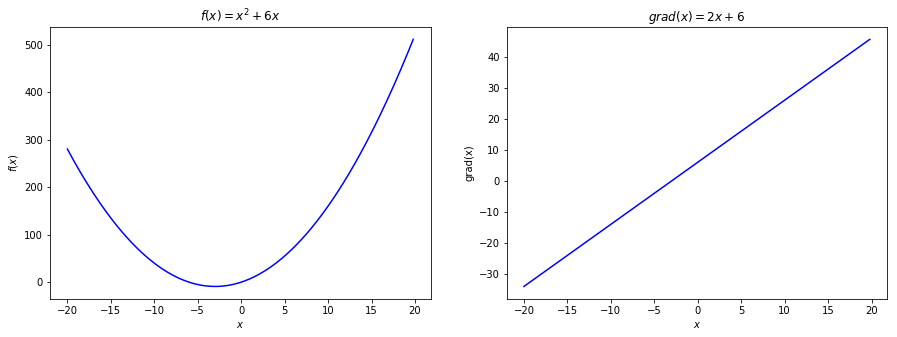

In [2]:
f = lambda x: (x ** 2 + 6 * x)
gradF = lambda x: (2 * x + 6)

x = np.arange(-20, 20, 0.2)

fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x, f(x), 'b-')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title('$f(x) = x^2 + 6x$')

plt.subplot(1, 2, 2)
plt.plot(x, gradF(x), 'b-')
plt.xlabel('$x$')
plt.ylabel('grad(x)')
plt.title('$grad(x) = 2x + 6$')
plt.show()

### Problem 1 (b)

One can perform gradient descent either by providing the gradient explicitly or by computing the gradient numerically. We try both these methods and show the solution below.

In [3]:
def gradient(f, x, *args, **kwargs):
    res = []
    if np.array(x).shape == ():
        h = x * 1e-10 ** (1 / 3) if x != 0 else 1e-10
        return (f(x + h, *args, **kwargs) - f(x - h, *args, **kwargs)) / 2 / h
    
    x = list(x)     
    for i, xi in enumerate(x):
        h = xi * 1e-10 ** (1 / 3) if xi != 0 else 1e-10
        res.append((f(np.array(x[:i] + [x[i] + h] + x[(i + 1):]), *args, **kwargs) 
                   - f(np.array(x[:i]+ [x[i] - h] + x[(i + 1):]), *args, **kwargs)) / 2 / h)
    return np.array(res)

def gradientDescent(f=None, df=None, initX=None, 
                    lr=0.1, maxIters=1e5, eps=1e-6, history=False, *args, **kwargs):
    
    hist=[]
    
    if initX is None:
        x = np.random.uniform(-100, 100)
    else:
        x = initX
    i = 0
    
    if df is not None:
        grad = lambda x: df(x, *args, **kwargs)
    elif f is not None:
        grad = lambda x: gradient(f, x, *args, **kwargs)
    else:
        raise Exception('Provide either function or gradient!')
    
    while i < maxIters and np.linalg.norm(grad(x)) > eps:
        i += 1
        hist.append(x)
        x = x - lr * grad(x)
        
    return (x, hist) if history else x

#### Gradient descent with analytical form of the gradient

minimizer: -2.9999995513864874


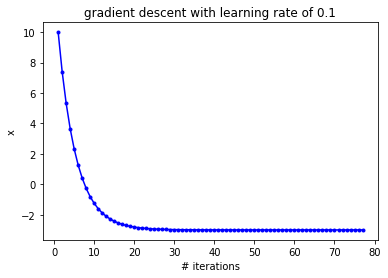

In [4]:
x_star, x_seq = gradientDescent(df=gradF, initX=10, history=True)
print(f'minimizer: {x_star}')

plt.plot(range(1, len(x_seq) + 1), x_seq, 'b.-')
plt.xlabel('# iterations')
plt.ylabel('x')
plt.title('gradient descent with learning rate of 0.1')
plt.show()

We can see that the minimum value is attained at $-3$ and hence matches with the analytical computation.

#### Gradient descent with numeric computation of the gradient

In [5]:
gradientDescent(f=f, initX=10)

-2.9999995513864004

We can see that this answer also matches with the analytical find.

### Problem 2 (a)

We first load the data in a dataframe. 

In [6]:
Oring_data = load_dataframe_csv('./Oring.csv')

In [7]:
Oring_data

,Temp,Failure
0,53,1
1,56,1
2,57,1
3,63,0
4,66,0
5,67,0
6,67,0
7,67,0
8,68,0
9,69,0


To normalize the `Temp` column, we use the following estimation of the mean and variance -- $\hat{\mu} = \frac{\sum_{n=1}^N x_n}{N}$, $\hat{\sigma}^2 = \frac{\sum_{n=1}^N (x_n -\hat{\mu})^2} {(N-1)}$. $N-1$ in the denominator makes estimator efficient. Commonly, $N$ is used in the denominator, as for large $N$ there is little difference between using $N$ and $(N - 1)$. In our case sample size is small, so we need to be more careful while deriving the estimator.

In [8]:
class Normalizer:
    def fit(self, data):
        self.mu = np.average(data)
        self.sigma = (sum((data - self.mu) ** 2) / (len(data) - 1)) ** 0.5
        
    def scale(self, data):
        return (data - self.mu) / self.sigma
    
    def fitAndScale(self, data):
        self.fit(data)
        return self.scale(data)

In [9]:
Oring_data_scaled = pd.DataFrame(columns=['Temp', 'Failure'])
Oring_data_scaled['Failure'] = Oring_data['Failure']
norm = Normalizer()
Oring_data_scaled['Temp'] = norm.fitAndScale(Oring_data['Temp'])

In [10]:
train_data = Oring_data_scaled['Temp'].to_numpy().reshape(-1, 1)
train_labels = Oring_data_scaled['Failure'].to_numpy().reshape(-1, 1)

The transformed data is given as follows.

In [11]:
Oring_data_scaled

,Temp,Failure
0,-2.293007,1
1,-1.886366,1
2,-1.750818,1
3,-0.937535,0
4,-0.530893,0
5,-0.395346,0
6,-0.395346,0
7,-0.395346,0
8,-0.259799,0
9,-0.124252,0


### Problem 2 (b)

Given a collection of training data $(\mathbf{x}_n, y_n)_{n=1}^{N}$, the objective function of the logistic regression model can be written as follows:
$$J(\mathbf{\tilde{w}}) = -\frac{1}{N}\sum_{n=1}^{N} (y_n \text{log}(h_{\mathbf{\tilde{w}}}(\mathbf{x}_n)) + (1 - y_n) \text{log}(1 - h_{\mathbf{\tilde{w}}}(\mathbf{x}_n))).$$ Here $\mathbf{x}_n \in \mathbb{R}^{D}$ is the $D$-dimensional feature pressentation for the $n^{\text{th}}$ data point. $\mathbf{w} \in \mathbb{R}^{D}$ is the set of coefficients corresponding to the $D$ features and $w_0$ is the bias term; together they compose $\mathbf{\tilde{w}} = (w_0, \mathbf{w})$ -- the parameters of a logistic regression model that one needs to learn from the training data. Also, $h_{\mathbf{\tilde{w}}}(\mathbf{x}_n) = \sigma(w_0 + \langle \mathbf{w}, \mathbf{x}_n\rangle)$ and $\sigma(x) = \frac{1}{1 + \text{exp}(-x)}$ is the logistic sigmoid function.

Note that this realization of the objective function follows directly from the maximum likelihood formulation. Given a training data $(\mathbf{x}_n, y_n)_{n=1}^{N}$, one is interested in modeling the joint likelihood of the targets $\{y_n\}_{n=1}^{N}$ as:
$$p(\{y_n\}_{n=1}^{N}| \mathbf{\tilde{w}}) = \prod_{n=1}^{N} h_{\mathbf{\tilde{w}}}(\mathbf{x}_n)^{y_n} (1 - h_{\mathbf{\tilde{w}}}(\mathbf{x}_n)^{(1- y_n)}.$$ The product over all the training data points is derived from the i.i.d assumption. Since our objective is to maximize this likelihood, we can use a monotonic transformation on this likelihood, such as logarithm, without changing the maximizer. Taking logarithm of the above likelihood gives rise to the log-likehood function. Maximizing this log-likehood is equivalent to minimizing the negative of the log-likelihood, which we state in the beginning of this section (we also divide the objective function by $N$ without changing the minimizer, this aspect will be important when we introduce the regularization term next). One can also show that the objective function is convex by calculating the Hessian at any point and showing that the Hessian matrix truns out to be positive-semidefinite. 

Often one introduces an $L_2$ regularization term to prevent overfitting in a logistic regresssion model. With such regularization, the object gets slightly modified to: $$J(\mathbf{\tilde{w}}) = -\frac{1}{N} \sum_{n=1}^{N} (y_n \text{log}(h_{\mathbf{\tilde{w}}}(\mathbf{x}_n)) + (1 - y_n) \text{log}(1 - h_{\mathbf{\tilde{w}}}(\mathbf{x}_n))) + \frac{\lambda}{2N} ||\mathbf{w}||_{2}^{2}$$
where $\lambda$ is the regularization parameter. With such modified objective, the gradient is derived as below: $$\frac{\partial J}{\partial \mathbf{\tilde{w}}} = \frac{1}{N}(- \sum_{n=1}^{N} (y_n - h_{\mathbf{\tilde{w}}}(\mathbf{x}_n)), (\lambda \mathbf{w} - \sum_{n=1}^{N} (y_n - h_{\mathbf{\tilde{w}}}(\mathbf{x}_n)) \mathbf{x}_n)).$$

The code below for logistic regression accepts such regularization parameter and learns the model parameters $\mathbf{\tilde{w}}$ corresponding to the objective above. Since the objective function is convex, the value of it decreases with every iteration of gradient descent when the learning rate $\eta$ is set appropriately. When $\eta$ is too high, the objective function osciallatates and no converegnce is achieved. We explicitly show these behaviors by varying the values of $\eta$. When $\eta$ is too low, the convergence is expectedly very slow. We analyze such behaviors in the Appendix.

In [12]:
class RegLogisticRegression:

    def __init__(self, max_iters=1000, learning_rate=0.01, regularizer=1.0, precision=1e-10, useNumericalGrad=False):
        # gradient descent specific parameters
        self.max_iters = max_iters
        self.learning_rate = learning_rate
        self.precision = precision
        self.regularizer = regularizer
        # training data, training labels and test labels
        self.x_train, self.y_train, self.y_pred, self.num_training = None, None, None, None
        # model parameters
        self.w = None
        # variables that keep track of the parameters and cost function for all the iterations
        self.w_epoch, self.cost_epoch = [], []
        
        self.useNumericalGrad=useNumericalGrad

    def gradient_descent(self):
        """
        gradient descent for logistic regression
        """
        if self.useNumericalGrad:
            grad = None
        else:
            grad = self.gradient_function
            
        self.w, self.w_epoch = gradientDescent(f=self.cost_function, df=grad, lr=self.learning_rate, 
                                 initX=self.w, maxIters=self.max_iters, history=True)
        self.cost_epoch = [self.cost_function(w) for w in self.w_epoch]
        

    def gradient_function(self, w):
        """
        gradient vector of logistic regression
        """
        x_dot_w = np.dot(self.x_train, w[:-1]) + w[-1]
        part_one = - np.dot(np.transpose(self.x_train), 
                            (self.y_train - sigmoid_function(x_dot_w))) + self.regularizer * w[:-1]
        part_two = - np.sum(self.y_train - sigmoid_function(x_dot_w))
        grad_vec_one = (1.0 / self.num_training) * part_one
        grad_vec_two = (1.0 / self.num_training) * part_two        
        grad_vec = np.append(grad_vec_one, [[grad_vec_two]], axis=0)

        return grad_vec

    def cost_function(self, w):
        """
        cost function of logistic regression
        """
        ones_vector = np.ones((self.num_training, 1))
        x_dot_w = np.dot(self.x_train, w[:-1]) + w[-1]      

        part_one = - np.dot(np.transpose(self.y_train), log_sigmoid_function(x_dot_w)).item()
        part_two = - np.dot(np.transpose(ones_vector - self.y_train), 
                            np.log(ones_vector - sigmoid_function(x_dot_w))).item()
        part_three = 0.5 * (self.regularizer * (ellp_norm(w[:-1], 2)**2)) 
        
        obj_val = (1.0 / self.num_training) * (part_one + part_two + part_three)

        return obj_val

    def train(self, x_train, y_train):
        """
        training process of logistic regression
        """
        self.x_train = x_train
        self.y_train = y_train
        self.num_training = len(y_train)
        self.w = np.ones((self.x_train.shape[1] + 1, 1))
        self.gradient_descent()

    def predict(self, x_test, y_test=None):
        """
        prediction of logistic regression
        """
        return sigmoid_function(np.dot(x_test, self.w[:-1]) + self.w[-1])

    def show_formula(self):
        """
        shows the formula of the model
        """
        display(Markdown('$p(y=1|x)=\\frac{1}{1+e^{-(' + str(self.w.T[0][::-1]) + ', [1,x])}}$'))

We now train two different logistic regression models -- one without regularization and the other with regularization.

#### Unregularized Logistic Regression, step-size $\eta=0.1$,  regularization $\lambda=0$

$p(y=1|x)=\frac{1}{1+e^{-([-1.10276034 -1.26384111], [1,x])}}$

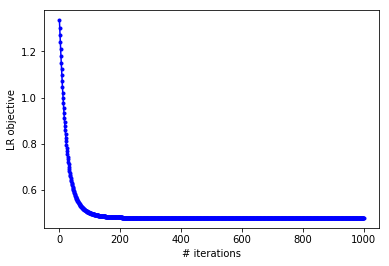

In [13]:
lr_model = RegLogisticRegression(learning_rate=0.1, regularizer=0)
lr_model.train(train_data, train_labels)
lr_model.show_formula()

plt.plot(range(1, len(lr_model.cost_epoch) + 1), lr_model.cost_epoch, 'b.-')
plt.xlabel('# iterations')
plt.ylabel('LR objective')
plt.show()

Quick check with sklearn:

In [14]:
LR = LM.LogisticRegression(C=np.Inf)
LR.fit(np.array(train_data).reshape(-1, 1), train_labels.ravel())
np.hstack((LR.intercept_[:,None], LR.coef_))

array([[-1.10281036, -1.26391916]])

#### Regularized Logistic Regression, step-size $\eta=0.1$,  regularization $\lambda=1$

$p(y=1|x)=\frac{1}{1+e^{-([-1.02631906 -0.95262762], [1,x])}}$

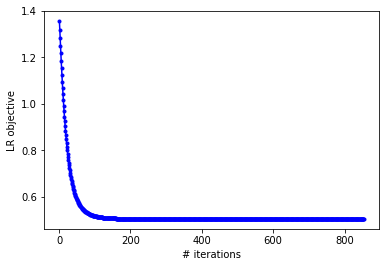

In [15]:
lr_model_reg = RegLogisticRegression(learning_rate=0.1, regularizer=1)
lr_model_reg.train(train_data, train_labels)
lr_model_reg.show_formula()


plt.plot(range(1, len(lr_model_reg.cost_epoch) + 1), lr_model_reg.cost_epoch, 'b.-')
plt.xlabel('# iterations')
plt.ylabel('LR objective')
plt.show()

Quick check with sklearn:

In [16]:
LR = LM.LogisticRegression()
LR.fit(np.array(train_data).reshape(-1, 1), train_labels.ravel())
np.hstack((LR.intercept_[:,None], LR.coef_))

array([[-1.02632602, -0.95263306]])

We can see that the final values of the parameters that we learn are expectedly different between these two models.

### Problem 2 (c)

Finally, we show the outcomes below from the above two models. The training labels are given by blue dots and the model predictions are given in red.

#### Unregularized Logistic Regression

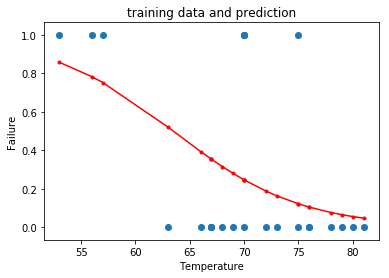

In [17]:
plt.scatter(Oring_data['Temp'], Oring_data['Failure'])
plt.plot(Oring_data['Temp'], lr_model.predict(train_data, train_labels), 'r.-')
plt.xlabel('Temperature')
plt.ylabel('Failure')
plt.title("training data and prediction")
plt.show()

#### Regularized Logistic Regression

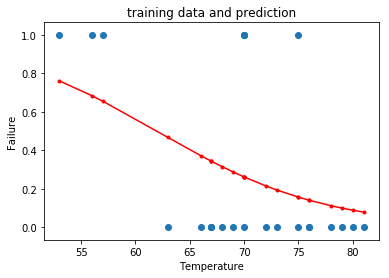

In [18]:
plt.scatter(Oring_data['Temp'], Oring_data['Failure'])
plt.plot(Oring_data['Temp'], lr_model_reg.predict(train_data, train_labels), 'r.-')
plt.xlabel('Temperature')
plt.ylabel('Failure')
plt.title("training data and prediction")
plt.show()

We can see that the prediction of both these models are quite similar. However, comparing prediction on the training data is not ideal and drawing any conclusion out of it, without an access to a held-out test set, is risky.

### Problem 2 (d)

In [19]:
test_point = norm.scale(31).reshape(-1, 1)

#### Unregularized Logistic Regression

In [20]:
print(f'probability of O-ring failure during the launch {lr_model.predict(test_point)}')

probability of O-ring failure during the launch [[0.99618146]]


#### Regularized Logistic Regression

In [21]:
print(f'probability of O-ring failure during the launch {lr_model_reg.predict(test_point)}')

probability of O-ring failure during the launch [[0.98199322]]


We can see that both the models predict that the probability of failure at launch would have been close to $1$. However, drawing any conclusion of either of these models could be risky because of the small sample size. Since we do not have access to a good test set (we evaluate the model only on single test point -- the challenger failure instance), we cannot evaluate the generalization error of these models. Finally, the generalization error is also contingent on the cost of false-positive and false-negative, which we do not have much idea about here. For example, we know that the cost of a false-negative prediction is catastrophic, but we are not sure what false-positive cost we might have to bear that is associated with launch date delays, government regulations, weather conditions etc.

### Appendix A: Gradient Descent with Varying Learning Rates

Since the method of gradient descent is quite sensitive to the learning rate, we explore the effect of the learning rate on the final solution. Our key observations are as follows:
- If the learning rate is set too high, gradient descent does not converge.
- If the learning rate is set appropriatly, gradient descent converges quickly.
- If the learning rate is set to a very small value, the convergence is very slow.

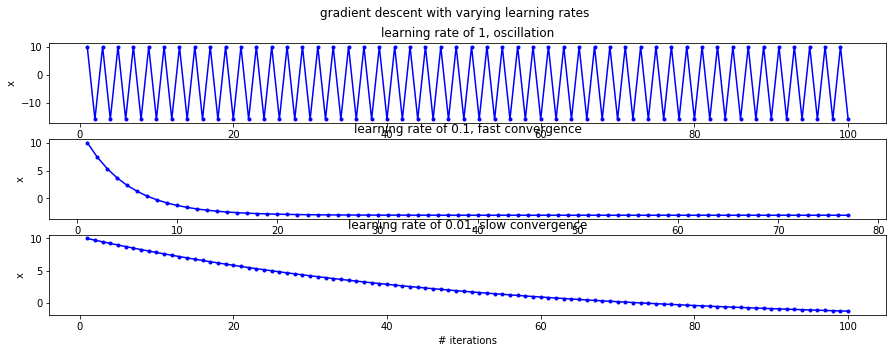

In [22]:
fig = plt.figure(figsize=(15, 5))

plt.suptitle('gradient descent with varying learning rates')
plt.subplot(3, 1, 1)

x_star, x_seq = gradientDescent(df=gradF, initX=10, maxIters=100, lr=1, history=True)
plt.plot(range(1, len(x_seq) + 1), x_seq, 'b.-')
plt.title('learning rate of 1, oscillation')
plt.xlabel('# iterations')
plt.ylabel('x')

plt.subplot(3, 1, 2)
x_star, x_seq = gradientDescent(df=gradF, initX=10, maxIters=100, lr=0.1, history=True)
plt.plot(range(1, len(x_seq) + 1), x_seq, 'b.-')
plt.title('learning rate of 0.1, fast convergence')
plt.xlabel('# iterations')
plt.ylabel('x')

plt.subplot(3, 1, 3)
x_star, x_seq = gradientDescent(df=gradF, initX=10, maxIters=100, lr=0.01, history=True)
plt.plot(range(1, len(x_seq) + 1), x_seq, 'b.-')
plt.title('learning rate of 0.01, slow convergence')
plt.xlabel('# iterations')
plt.ylabel('x')

plt.show()

### Appendix B: Logistic Regression with Varying Learning Rates

We also demonstrate the same behavior from the logistic regression model by varying the learning rate.

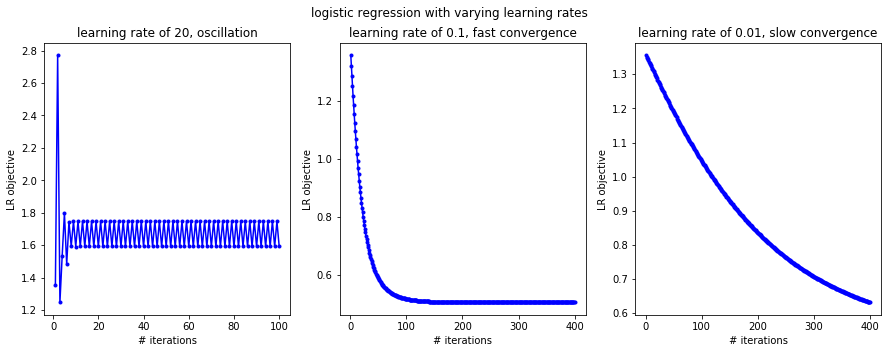

In [23]:
fig = plt.figure(figsize=(15, 5))

plt.suptitle('logistic regression with varying learning rates')

plt.subplot(1, 3, 1)

lr_model_one = RegLogisticRegression(max_iters=100, learning_rate=20, regularizer=1.0)
lr_model_one.train(train_data, train_labels)
plt.plot(range(1, len(lr_model_one.cost_epoch) + 1), lr_model_one.cost_epoch, 'b.-')
plt.title('learning rate of 20, oscillation')
plt.xlabel('# iterations')
plt.ylabel('LR objective')

plt.subplot(1, 3, 2)
lr_model_two = RegLogisticRegression(max_iters=400, learning_rate=0.1, regularizer=1.0)
lr_model_two.train(train_data, train_labels)
plt.plot(range(1, len(lr_model_two.cost_epoch) + 1), lr_model_two.cost_epoch, 'b.-')
plt.title('learning rate of 0.1, fast convergence')
plt.xlabel('# iterations')
plt.ylabel('LR objective')

plt.subplot(1, 3, 3)
lr_model_three = RegLogisticRegression(max_iters=400, learning_rate=0.01, regularizer=1.0)
lr_model_three.train(train_data, train_labels)
plt.plot(range(1, len(lr_model_three.cost_epoch) + 1), lr_model_three.cost_epoch, 'b.-')
plt.title('learning rate of 0.01, slow convergence')
plt.xlabel('# iterations')
plt.ylabel('LR objective')

plt.show()

Note that one can get rid of the problem of tuning the learning rate if a second order method is used for optimization. Such method is a bit more compute-heavy, for the calculation of the Hessian, but regardless comes in handy when the number of features is not too large. Note that the second order methods need to calculate the inverse of the Hessian matrix, whose computation cost scales as $O(D^3)$, where $D$ is the number of features in the data.

### Appendix C: Logistic Regression with Numerical Computation of Gradient

In [24]:
lr_model = RegLogisticRegression(learning_rate=0.1, regularizer=0, useNumericalGrad=True)
lr_model.train(train_data, train_labels)
lr_model.show_formula()

$p(y=1|x)=\frac{1}{1+e^{-([-1.10276037 -1.26384118], [1,x])}}$

In [25]:
lr_model_reg = RegLogisticRegression(learning_rate=0.1, regularizer=1, useNumericalGrad=True)
lr_model_reg.train(train_data, train_labels)
lr_model_reg.show_formula()

$p(y=1|x)=\frac{1}{1+e^{-([-1.02631908 -0.95262765], [1,x])}}$

As it can be seen, results obtained with numerical computation of gradient match results obtained with analytical form of gradient. However, as it is more computationly intense, analytical form is prefered.